In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from scipy import stats

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt

from Bio import SeqIO

from mhcflurry import predict
from mhcflurry import class1_allele_specific

from __future__ import print_function

# from Levenshtein import hamming
from multiprocessing import Pool, Process

Using Theano backend.
/home/vts/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
! export KERAS_BACKEND=theano

Loading files:

In [4]:
record_dict = SeqIO.index("data/UP000005640_9606.fasta", "fasta")

In [16]:
def get_kmers(length, record_dict):
    filename = 'output/peptides_raw.txt'
    target = open(filename, 'w+')
    for key in tqdm_notebook(record_dict):
        lines = []
        for i in range(len(record_dict[key].seq)-length):
            lines.append(str(record_dict[key].seq[i:i+length]))
        for i in range(len(lines)):
            target.write(lines[i]+'\n')
    target.close()

100%|██████████| 21033/21033 [09:11<00:00, 45.85it/s]   


In [18]:
df = pd.read_csv('output/peptides_raw.txt', index_col=False)
df.shape

(11314571, 1)

In [19]:
! sort output/peptides_raw.txt | uniq > output/human_peptides.txt

In [2]:
df = pd.read_csv('output/human_peptides.txt', index_col=False)
df.columns = ['Peptide']
df.shape

(10379345, 1)

In [4]:
file1 = 'output/HLA-A0201.csv'
file2 = 'output/human_peptides.txt'
exceptions = 0
with open(file1, 'w') as output:
    output.write('Allele,Peptide,Prediction')
    output.write('\n')
    with open(file2, 'r') as peptides:
        for line in tqdm_notebook(peptides.readlines()):
            s = line.rstrip()
            try:
                prediction = predict(alleles=['HLA-A0201'], peptides=[s])
                output.write('{0},{1},{2}'.format(prediction.Allele.iloc[0], \
                                                prediction.Peptide.iloc[0], prediction.Prediction.iloc[0]))
                output.write('\n')
            except KeyError:
                exceptions += 1
                if (exceptions%10 == 0):
                    print(".", end='')
print('{} exceptions occured'.format(exceptions))


20445/|/  0%|| 20445/10379346 [01:25<11:58:53, 240.16it/s].........................
255 exceptions occured


In [2]:
df = pd.read_csv('output/HLA-A0201.csv', index_col=False)

In [3]:
df.head()

,Allele,Peptide,Prediction
0,HLA-A0201,AAAAAAAAA,3140.859375
1,HLA-A0201,AAAAAAAAC,9386.266602
2,HLA-A0201,AAAAAAAAD,19053.091797
3,HLA-A0201,AAAAAAAAE,13797.026367
4,HLA-A0201,AAAAAAAAF,11891.204102


In [9]:
len(df[df["Prediction"] <= 500])

409088

Code to create sample file

In [20]:
with open('output/HLA-A0201.csv', 'r') as file:
    with open('output/sample100000.txt', 'w') as file1:
        for i, line in enumerate(file):
            file1.write(line)
            if i == 100000:
                break

Hamming distance

In [2]:
data = pd.read_csv('output/HLA-A0201.csv', index_col=False)
data.shape

(10379091, 3)

In [10]:
binding = data[data["Prediction"] <= 500]

In [26]:
binding['Peptide'].describe()

count        409088
unique       409088
top       NLNAGSNVV
freq              1
Name: Peptide, dtype: object

In [5]:
list2 = []
def ham_dist_dict(data, dist, line):
    dict_ = dict()
    for i, s_line in enumerate(data['Peptide']):
        result = hamming(line, s_line)
        if result <= dist:
            dict_[i] = result
    return dict_

pool = Pool(processes=4) 

for line in tqdm_notebook(binding['Peptide']):
#     result = pool.apply_async(ham_dist_dict, (binding, 1, line,)).get()
    result = pool.apply(ham_dist_dict, (binding, 1, line,))
#     result = ham_dist_dict(binding, 1, line)
    list2.append(result)

# pool.close()
# pool.join()

Process PoolWorker-18:
Process PoolWorker-20:
Process PoolWorker-19:
Process PoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/vcvetkov/anaconda3/envs/python2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/vcvetkov/anaconda3/envs/python2/lib/

KeyboardInterrupt: 

In [ ]:
for i, line in enumerate(result):
    print(line)
    if i == 1:
        break

In [6]:
edges_list = []
for vertex, edges in enumerate(list2):
    for target in edges:
        edges_list.append((vertex, target, edges[target]))

TypeError: 'ApplyResult' object is not iterable

In [12]:
g = nx.Graph()
g.add_weighted_edges_from(edges_list)

In [ ]:
Gc = max(nx.connected_component_subgraphs(g), key=len)
number_of_nodes(Gc)

petide-binding preferences

In [11]:
freq = np.zeros((20,9))
aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

for line in tqdm_notebook(binding['Peptide']):
    for i, a in enumerate(line):
        try:
            freq[int(aa[a]), i] = freq[aa[a],i]+1
        except KeyError:
            pass
freq_norm = np.true_divide(freq, 409088)
freq_norm_r = np.round(freq_norm, 2)
freq_norm_r

array([[ 0.08,  0.04,  0.09,  0.09,  0.08,  0.06,  0.08,  0.08,  0.12],
       [ 0.01,  0.  ,  0.02,  0.03,  0.03,  0.03,  0.02,  0.02,  0.01],
       [ 0.  ,  0.  ,  0.05,  0.07,  0.03,  0.03,  0.03,  0.02,  0.  ],
       [ 0.01,  0.  ,  0.03,  0.08,  0.04,  0.03,  0.04,  0.06,  0.  ],
       [ 0.11,  0.02,  0.07,  0.04,  0.07,  0.06,  0.08,  0.07,  0.01],
       [ 0.06,  0.01,  0.05,  0.08,  0.07,  0.04,  0.04,  0.06,  0.03],
       [ 0.02,  0.  ,  0.02,  0.02,  0.03,  0.02,  0.03,  0.02,  0.  ],
       [ 0.06,  0.08,  0.07,  0.04,  0.06,  0.08,  0.06,  0.04,  0.11],
       [ 0.07,  0.  ,  0.01,  0.03,  0.03,  0.02,  0.02,  0.03,  0.  ],
       [ 0.15,  0.55,  0.19,  0.1 ,  0.14,  0.2 ,  0.15,  0.14,  0.28],
       [ 0.04,  0.1 ,  0.05,  0.02,  0.02,  0.03,  0.03,  0.02,  0.03],
       [ 0.02,  0.  ,  0.03,  0.04,  0.03,  0.04,  0.03,  0.03,  0.  ],
       [ 0.  ,  0.  ,  0.04,  0.06,  0.03,  0.06,  0.07,  0.08,  0.01],
       [ 0.03,  0.05,  0.04,  0.03,  0.03,  0.03,  0.03,  0.03, 

In [12]:
aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))

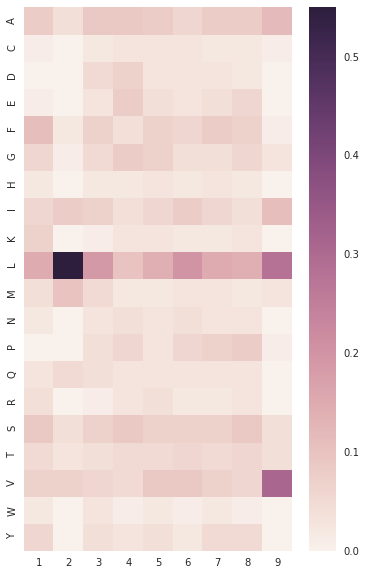

In [13]:
fig = plt.figure(figsize=(6,10))
ax = sns.heatmap(aa_df)

In [5]:
freq = np.zeros((20,9))
aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

for line in tqdm_notebook(data['Peptide']):
    for i, a in enumerate(line):
        try:
            freq[int(aa[a]), i] = freq[aa[a],i]+1
        except KeyError:
            pass
freq_norm = np.true_divide(freq, 10379091)
freq_norm_r = np.round(freq_norm, 2)
freq_norm_r

array([[ 0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07],
       [ 0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02],
       [ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05],
       [ 0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07],
       [ 0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04],
       [ 0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07,  0.07],
       [ 0.03,  0.03,  0.03,  0.03,  0.03,  0.03,  0.03,  0.03,  0.03],
       [ 0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04],
       [ 0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06],
       [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ],
       [ 0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02],
       [ 0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04],
       [ 0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06,  0.06],
       [ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05, 

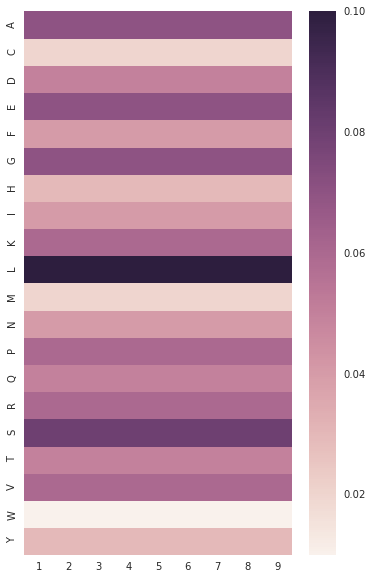

In [9]:
aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))
fig = plt.figure(figsize=(6,10))
ax = sns.heatmap(aa_df)

In [3]:
def make_prediction(file):
    file1 = file
    file2 = 'output/human_peptides.txt'
    exceptions = 0
    with open(file1, 'w+') as output:
        output.write('Allele,Peptide,Prediction')
        output.write('\n')
        with open(file2, 'r') as peptides:
            for line in tqdm_notebook(peptides.readlines()):
                s = line.rstrip()
                try:
                    prediction = predict(alleles=[file1.split('/')[1].strip('.csv')], peptides=[s])
                    output.write('{0},{1},{2}'.format(prediction.Allele.iloc[0], \
                                                    prediction.Peptide.iloc[0], prediction.Prediction.iloc[0]))
                    output.write('\n')
                except KeyError:
                    exceptions += 1
                    if (exceptions%10 == 0):
                        print(".", end='')
    return '{} exceptions occured'.format(exceptions)

aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

def count_freq(filepath):
    if "NMP" in filepath:
        data = read_NMP(filepath)
    else:
        data = pd.read_csv(filepath, index_col=False)
    binding = data[data["Prediction"] <= 500]
    freq = np.zeros((20,9))
    for line in tqdm_notebook(binding['Peptide']):
        for i, a in enumerate(line):
            try:
                freq[int(aa[a]), i] = freq[aa[a],i]+1
            except KeyError:
                pass
    freq_norm = np.true_divide(freq, 409088)
    freq_norm_r = np.round(freq_norm, 2)
    aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))
    return aa_df

def plot_freq(aa_df):
    fig = plt.figure(figsize=(6,10))
    ax = sns.heatmap(aa_df)

def plot_entr(input_df):
    sns.set_context("notebook")
    df = pd.DataFrame([stats.entropy(input_df[i], base=2) for i in input_df.columns], columns = ['entropy'])
    df['position'] = input_df.columns
    clrs = ['grey' if x > 3 else 'red' for x in df['entropy']]
    sns.barplot(data=df, x='position', y='entropy', palette = clrs)
    
def read_NMP(filepath):
    with open(filepath, "r") as file:
        d = file.readlines()
        data = [x.split() for x in d[44:-5]]
        for i, line in tqdm_notebook(enumerate(file)):
            if i == 44:
                columns = line.split()
                break
    df = pd.DataFrame(data, columns=columns)
    df = df.ix[2:,("HLA", "Peptide", "Aff(nM)")]
    df.columns = ['Allele', 'Peptide', 'Prediction']
    df.index = range(len(df))
    return df

In [3]:
make_prediction('output/HLA-A0217.csv')

.........................


'255 exceptions occured'

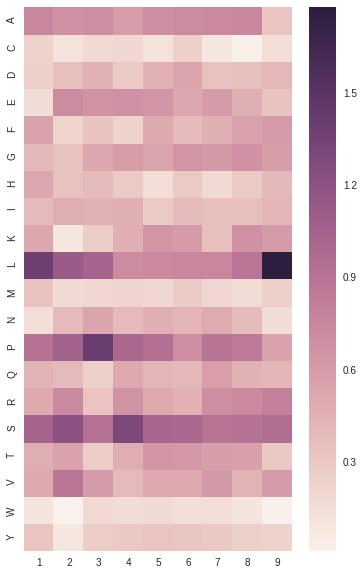

In [4]:
freq_HLA_A0217 = count_freq('output/HLA-A0217.csv')
plot_freq(freq_HLA_A0217)
# Doesn't really look like
# https://link.springer.com/article/10.1007/s002510050538
# Although it is tough to compare, coz they didn't bother themselves normalizing the data

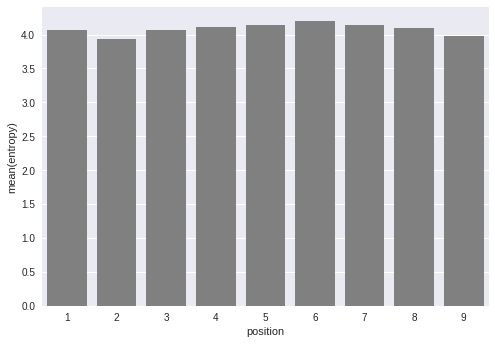

In [5]:
plot_entr(freq_HLA_A0217)

<img style="float: left;" src="data/HLA-A2anchors.png">

In [4]:
make_prediction('output/HLA-B1402.csv')

.........................


'255 exceptions occured'

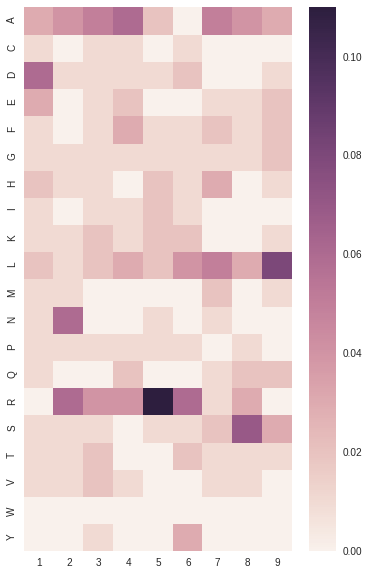

In [6]:
freq_HLA_B1402 = count_freq('output/HLA-B1402.csv')
plot_freq(freq_HLA_B1402)
# http://www.jbc.org/content/269/51/32426.full.pdf

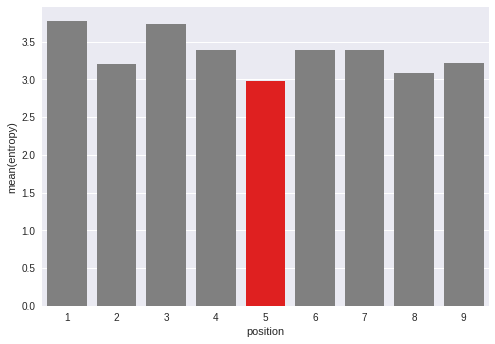

In [7]:
plot_entr(freq_HLA_B1402)

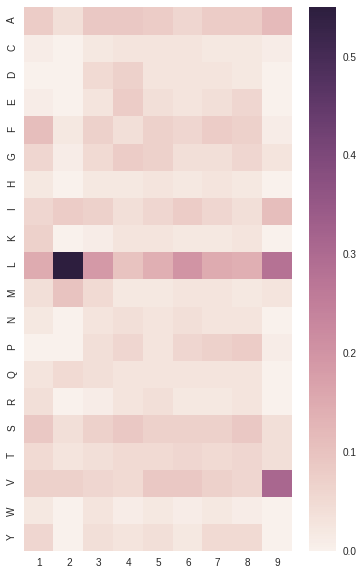

In [8]:
freq_HLA_A0201 = count_freq('output/HLA-A0201.csv')
plot_freq(freq_HLA_A0201)

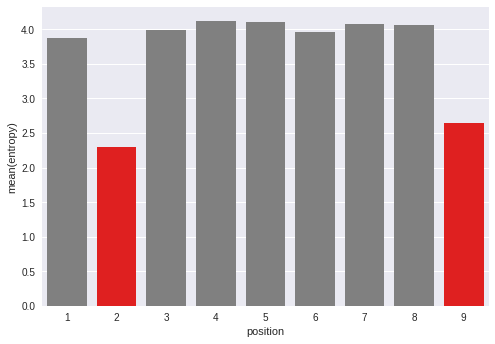

In [9]:
plot_entr(freq_HLA_A0201)

In [10]:
make_prediction('output/HLA-A0202.csv')

.........................


'255 exceptions occured'

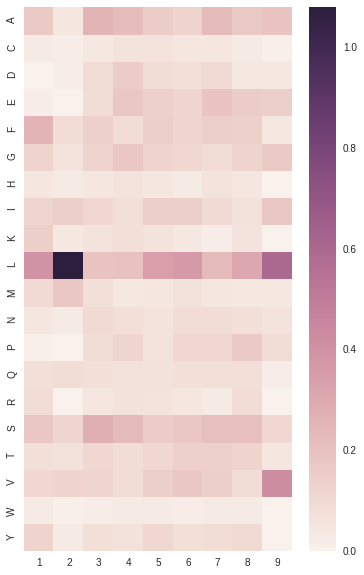

In [13]:
freq_HLA_A0202 = count_freq('output/HLA-A0202.csv')
plot_freq(freq_HLA_A0202)

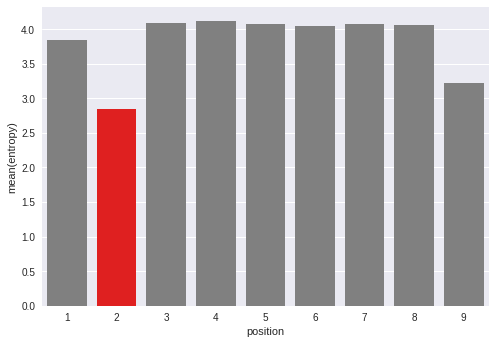

In [14]:
plot_entr(freq_HLA_A0202)

In [ ]:
# make_prediction('output/HLA-A0204.csv') mhcflurry doesn't predict this one
# make_prediction('output/HLA-A0205.csv') neither this one
make_prediction('output/HLA-A0206.csv')

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '10866' (I am process '4936')


In [4]:
df = pd.read_csv('output/HLA-A0206.csv')
df.shape

(581480, 3)

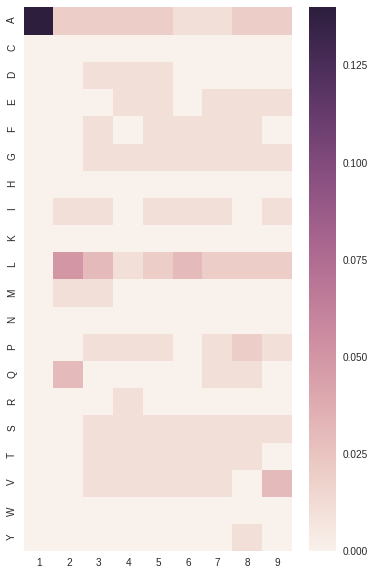

In [8]:
freq_HLA_A0206 = count_freq('output/HLA-A0206.csv')
plot_freq(freq_HLA_A0206)

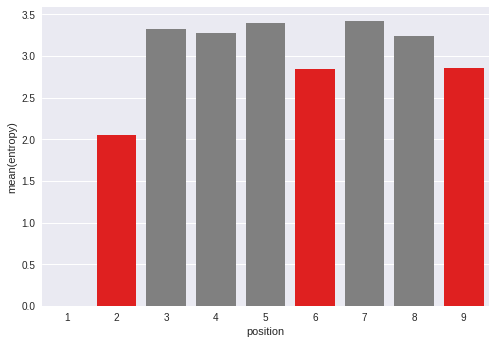

In [9]:
plot_entr(freq_HLA_A0206) # Looks suspiciously

NetMHCpan predictions

In [ ]:
# freq_HLA_A0201 = count_freq('output/HLA-A0201.csv')
# plot_freq(freq_HLA_A0201)
df = read_NMP("output/HLA-A02:01_NMP.txt")